# code to work out major icetype per region per season

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from scipy import stats
from netCDF4 import Dataset
from scipy.interpolate import griddata
import datetime
from regrid import regrid
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import cartopy
import os
import pickle

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# download icetypes for each season

In [2]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020','2020-2021']

grid_res = 50
dX = 160
dY = 160
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy')
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy')

def download(date):
    datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
    date_split = list(date)
    year = date_split[0]+date_split[1]+date_split[2]+date_split[3]
    month = date_split[4]+date_split[5]
    import shutil
    import urllib.request as request
    from contextlib import closing
    with closing(request.urlopen('ftp://osisaf.met.no//archive/ice/type/'+year+'/'+month+'//ice_type_nh_polstere-100_multi_'+date+'1200.nc')) as r:
        with open(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+date+'1200.nc', 'wb') as f:
            shutil.copyfileobj(r, f)

def icetype():
    datapath1 = datapath + '/CS2_CPOM'
    if os.path.exists(datapath+'/icetype/icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')==False:
        if os.path.exists(datapath+'/icetype')==False:
            os.mkdir(datapath+'/icetype')
        f = open(datapath1+'/dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')

        FB_all = pickle.load(f)
        FB_FYI = np.zeros((dX,dY,len(FB_all)))*np.nan
        FB_MYI = np.zeros((dX,dY,len(FB_all)))*np.nan
        icetype_grid = np.zeros((dX,dY,len(FB_all)))*np.nan
        FB_dates = []
        k = 0
        for key in FB_all: #key is a date, so looping through each day for which we have gridded CS2 obs in this season
            print('Downloading OSI-SAF icetype: ',key)
            download(key)
            FB_dates.append(key)
            try:
                FB = FB_all[key]
            except:
                print('KeyError')
            fbFYI = np.zeros((dX,dY))*np.nan
            fbMYI = np.zeros((dX,dY))*np.nan
            icetype = Dataset(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+str(key)+'1200.nc')
            icetype_lon = np.array(icetype['lon'])
            icetype_lat = np.array(icetype['lat'])
            icetype_x,icetype_y = m(icetype_lon,icetype_lat)
            itype = np.array(icetype['ice_type']).astype('float32')[0,:,:]
            itype[itype>3] = np.nan
            itype[itype<2] = np.nan
            icetype_grid[:,:,k] = griddata((icetype_x.ravel(),icetype_y.ravel()),itype.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
            k += 1
        np.save(datapath+'/icetype/icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy',icetype_grid)
    else:
        pass

for season in seasons:
    print(season)
    try:
        icetype()
        print('data loaded')
    except:
        print('no data this year')

2010-2011
data loaded
2011-2012
data loaded
2012-2013
data loaded
2013-2014
data loaded
2014-2015
data loaded
2015-2016
data loaded
2016-2017
data loaded
2017-2018
data loaded
2018-2019
data loaded
2019-2020
data loaded
2020-2021
data loaded


# work out major icetype per season per region

In [3]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/'
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020','2020-2021']

grid_res = 50
dX = 160
dY = 160
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy')
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy')

WG_lat = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
WG_lon = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')
nsidc_lat = np.fromfile('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/psn25lats_v3.dat',dtype='<i4').reshape(448,304)/100000
nsidc_lon = np.fromfile('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/psn25lons_v3.dat',dtype='<i4').reshape(448,304)/100000
file = Dataset('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/NSIDC_regions_Masks-2.nc')
mask = np.array(file['mask']).transpose(1,0).astype('float32')
mask_values = regrid(mask, nsidc_lon, nsidc_lat, WG_lon, WG_lat,'nearest')
#lats = np.load(datapath+'Robbie_lat.npy')

datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/'
print('major icetype for full season:')

for season in seasons:
    print(season)
    try:
        icetype_grid = np.load(datapath+'icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')

        for regs, reg_name in zip([[9], [10], [11], [12], [13], [14], [15]], 
                      ['Kara', 'Laptev', 'E. Siberian', 'Chukchi','Beaufort', 'Can. Arch', 'Central Arctic']):
            ice_mean = []
            reg = np.where((mask_values==regs))
            for i in range(181):
                icetype_grid_c = icetype_grid.copy()
                icetype_grid_c[np.where((WG_lat[:-1,:-1]>88))] = np.nan
                mean = np.nanmean(icetype_grid_c[:,:,i][reg])
                ice_mean.append(mean)

            reg_mean = np.nanmean(ice_mean)
            if reg_mean<2.5:
                print(reg_name,'FYI')
            if reg_mean>2.5:
                print(reg_name,'MYI')

    except:
        pass

major icetype for full season:
2010-2011
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2011-2012
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2012-2013
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2013-2014
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort MYI
Can. Arch FYI
Central Arctic MYI
2014-2015
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort MYI
Can. Arch FYI
Central Arctic MYI
2015-2016
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2016-2017
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2017-2018
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2018-2019
Kara FYI
Laptev FYI
E. Siberian FYI
Chukchi FYI
Beaufort FYI
Can. Arch FYI
Central Arctic MYI
2019-2020
Kara FYI
Laptev FYI
E. 

Text(0.5, 1.0, 'Correlation between SM-LG and CS2_CPOM interpolated freeboards smoothed anomalies for full 2010-2020 period')

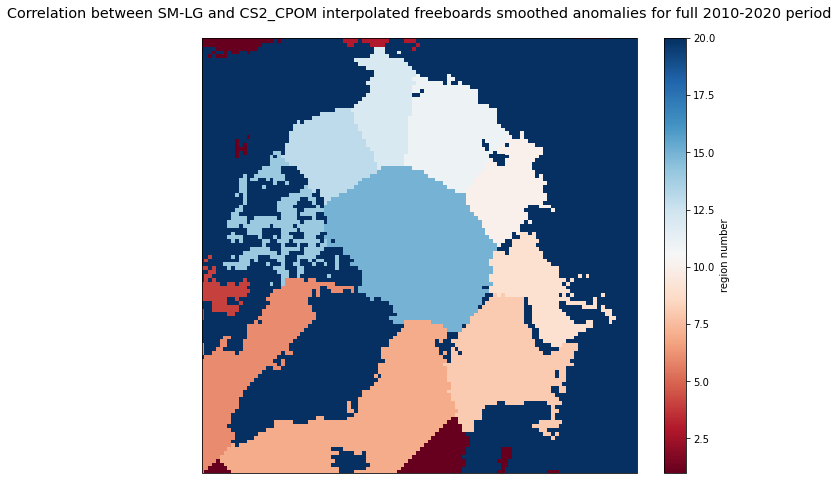

In [9]:
# cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(WG_lon,WG_lat,mask_values,cmap='RdBu',vmin=1,vmax=20,transform=ccrs.PlateCarree())
a = fig.colorbar(p_map)
a.set_label('region number')

9 = Kara, 
10 = Laptev, 
11 = E. Siberian, 
12 = Chukchi, 
13 = Beaufort, 
14 = Can. Arch., 
15 = Central Arctic